# Install dependencies.

Pandas for Dataframes

PGMPY for Bayesian Network

In [129]:
! pip install pandas;
! pip install pgmpy;

# Import dependencies

Import Pandas, Bayesian Network, Bayesian Estimator and VariableElimination

In [130]:
import pandas as pd
from pgmpy.models import BayesianNetwork
from pgmpy.estimators import BayesianEstimator
from pgmpy.inference import VariableElimination

# Define Constants

Define constants for column names


In [131]:
Quali = "Qualifikation"
S = "Schnitt"
BL = "Bundesland"
M = "Mathe"
P = "Physik"
D = "Deutsch"
ST = "Schultyp"
OLTM = "OLT-Mathe"
OLTD = "OLT-Deutsch"
SFT = "Studierfähigkeitstest"
A = "Alter"
Geschl = "Geschlecht"
JEDE = "Jahreseinkommen der Eltern"
SB = "Staatsbürgerschaft"
SG = "Studiengang"
Absch= "Abschluss"

# Load data and parse

Load data from "p001_1.csv" file and parse non-string variables

In [150]:
init_data = pd.read_csv('p001_1.csv', sep=';',dtype={
    Quali: "string",
    S: "string",
    BL: "string",
    M: "string",
    P: "string",
    D: "string",
    ST: "string",
    OLTM: "string",
    OLTD: "string",
    SFT: "string",
    A: "string",
    Geschl: "string",
    JEDE: "string",
    SB: "string",
    SG: "string",
    Absch: "string"
})


def parse_df(data:pd.DataFrame):
    # Define data types for numerical columns
    numerical_columns = [S, M, D, P, OLTM, OLTD, SFT, A, JEDE]
    values = [S, M, D, P]

    if Absch in data:
        numerical_columns.append(Absch)
        values.append(Absch)

    #Change a Komma to a dot to convert values 
    for column in values:
        data[column] = data[column].str.replace(",",".")
    #Parse string to numeric(int or float)
    for column in numerical_columns:
        if column not in data:
            continue
        data.loc[:, column] = pd.to_numeric(
            data[column], errors="coerce"
        )
    
    # Handle missing values in categorical columns
    categorical_columns = [Quali, BL, ST, Geschl, SB, SG]
    for column in categorical_columns:
        if column not in data:
            continue
        # Replace missing values with the most frequent category
        data.loc[:, column].fillna(data[column].mode()[0], inplace=True)
    
    return data

init_data = parse_df(init_data)

display(init_data)

,Qualifikation,Schnitt,Bundesland,Mathe,Physik,Deutsch,Schultyp,OLT-Mathe,OLT-Deutsch,Studierfähigkeitstest,Alter,Geschlecht,Jahreseinkommen der Eltern,Staatsbürgerschaft,Studiengang,Abschluss
0,Abitur,2.7,Baden-Württemberg,2.3,2.2,2.1,Allgemeinbildendes Gymnasium,63,62,685,19,m,47000,deutsch,Maschinenbau,3.0
1,Meister,1.6,Nordrhein-Westfalen,<NA>,<NA>,<NA>,n.a.,36,59,<NA>,25,m,87000,deutsch,Maschinenbau,<NA>
2,Abitur,1.8,Baden-Württemberg,1.0,1.1,1.2,Wirtschaftsgymnasium,96,94,<NA>,18,w,115000,deutsch,Soziale Arbeit,1.1
3,Abitur,1.1,Baden-Württemberg,2.5,2.7,1.9,Technisches Gymnasium,70,76,<NA>,17,m,115000,deutsch,Elektrotechnik,2.6
4,Abitur,1.4,Bayern,2.0,2.1,1.4,Wirtschaftsgymnasium,65,82,<NA>,17,m,90000,deutsch,Elektrotechnik,2.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,Abitur,1.4,Baden-Württemberg,2.4,2.5,2.5,Allgemeinbildendes Gymnasium,60,65,<NA>,19,w,107000,deutsch,Elektrotechnik,3.1
96,Abitur,2.6,Baden-Württemberg,1.1,1.1,1.2,Technisches Gymnasium,100,94,<NA>,20,m,80000,deutsch,Wirtschaftswissenschaften,1.5
97,Abitur,1.6,Baden-Württemberg,2.0,2.2,1.7,Technisches Gymnasium,76,86,<NA>,19,m,208000,deutsch,Maschinenbau,2.4
98,Abitur,2.6,Bayern,1.5,1.4,1.1,Allgemeinbildendes Gymnasium,80,86,<NA>,18,m,110000,deutsch,Maschinenbau,1.8


# Transform data 

Modify data to be more digestible and easily usable for the bayesian network

In [151]:
#Map Abschlussnote to "abgebrochen", "gut" or "bestehen"
def map_absch(value):
    #If not a number "abgebrochen"
    if pd.isna(value):
        return("abgebrochen")
    #Range 1-2.4 is "gut"
    elif value < 2.5:
        return("gut")
    #Anything worse then 2.4 is "bestehen"
    else:
        return("bestehen")
                
#Map Age to "Teen", "YoungAdult" or "Adult"
def map_age(value):
    if pd.isna(value):
        return(value)
    elif  value < 20:
        return("Teen")
    elif  value < 25:
        return("YoungAdult")
    else:
        return("Adult")

#Map Grade to "Sehr Gut", "Gut" or "Befriedigend", "Ausreichend" or "mangelhaft"
def map_grade(value):
    if pd.isna(value):
        return(value)
    elif  value < 2:
        return("Sehr Gut")
    elif  value < 3:
        return("Gut")
    elif  value < 4:
        return("Befriedigend")
    elif  value == 4:
        return("Ausreichend")
    else:
        return("mangelhaft")

#Map OLT-Values (Math or German) to "Sehr Gut", "Gut" or "Schlecht"
def map_olt(value):
    if pd.isna(value):
        return(value)
    elif  value < 50:
        return("Schlecht")
    elif  value < 75:
        return("Gut")
    else:
        return("Sehr Gut")

#Map Studienfähigkeitstest to "Sehr Gut", "Gut" or "Schlecht"
def map_sft(value):
    if pd.isna(value):
        return(value)
    elif  value < 600:
        return("Schlecht")
    elif  value < 750:
        return("Gut")
    else:
        return("Sehr Gut")

#Map JahreseinkommenderEltern to "Gering", "Mittel" or "Hoch"
def map_jede(value):
    if pd.isna(value):
        return(value)
    elif value < 60000:
        return("Gering")
    elif value < 100000:
        return("Mittel")
    else: 
        return("Hoch")

#Function to Transform all relevant Data in Dataframe to understandable String value
def transform_data(data:pd.DataFrame):
    if Absch in data:
        new_absch = []
        for value in data[Absch]:
            new_absch.append(map_absch(value))
        data[Absch] = new_absch

    if A in data:
        new_age = []
        for value in data[A]:
            new_age.append(map_age(value))
        data[A] = new_age

    grades = [M, D, P, S]

    for grade in grades:
        if grade not in data:
            continue
        new_grade = []
        for value in data[grade]:
            new_grade.append(map_grade(value))
        data[grade] = new_grade

    if OLTD in data:
        new_oltd = []
        for value in data[OLTD]:
            new_oltd.append(map_olt(value))
        data[OLTD] = new_oltd

    if OLTM in data:
        new_oltm = []
        for value in data[OLTM]:
            new_oltm.append(map_olt(value))
        data[OLTM] = new_oltm

    if SFT in data:
        new_sft = []
        for value in data[SFT]:
            new_sft.append(map_sft(value))
        data[SFT] = new_sft

    if JEDE in data:
        new_jede = []
        for value in data[JEDE]:
            new_jede.append(map_jede(value))
        data[JEDE] = new_jede

    return data

init_data = transform_data(init_data)

display(init_data)

,Qualifikation,Schnitt,Bundesland,Mathe,Physik,Deutsch,Schultyp,OLT-Mathe,OLT-Deutsch,Studierfähigkeitstest,Alter,Geschlecht,Jahreseinkommen der Eltern,Staatsbürgerschaft,Studiengang,Abschluss
0,Abitur,Gut,Baden-Württemberg,Gut,Gut,Gut,Allgemeinbildendes Gymnasium,Gut,Gut,Gut,Teen,m,Gering,deutsch,Maschinenbau,bestehen
1,Meister,Sehr Gut,Nordrhein-Westfalen,<NA>,<NA>,<NA>,n.a.,Schlecht,Gut,<NA>,Adult,m,Mittel,deutsch,Maschinenbau,abgebrochen
2,Abitur,Sehr Gut,Baden-Württemberg,Sehr Gut,Sehr Gut,Sehr Gut,Wirtschaftsgymnasium,Sehr Gut,Sehr Gut,<NA>,Teen,w,Hoch,deutsch,Soziale Arbeit,gut
3,Abitur,Sehr Gut,Baden-Württemberg,Gut,Gut,Sehr Gut,Technisches Gymnasium,Gut,Sehr Gut,<NA>,Teen,m,Hoch,deutsch,Elektrotechnik,bestehen
4,Abitur,Sehr Gut,Bayern,Gut,Gut,Sehr Gut,Wirtschaftsgymnasium,Gut,Sehr Gut,<NA>,Teen,m,Mittel,deutsch,Elektrotechnik,gut
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,Abitur,Sehr Gut,Baden-Württemberg,Gut,Gut,Gut,Allgemeinbildendes Gymnasium,Gut,Gut,NaN,Teen,w,Hoch,deutsch,Elektrotechnik,bestehen
96,Abitur,Gut,Baden-Württemberg,Sehr Gut,Sehr Gut,Sehr Gut,Technisches Gymnasium,Sehr Gut,Sehr Gut,NaN,YoungAdult,m,Mittel,deutsch,Wirtschaftswissenschaften,gut
97,Abitur,Sehr Gut,Baden-Württemberg,Gut,Gut,Sehr Gut,Technisches Gymnasium,Sehr Gut,Sehr Gut,NaN,Teen,m,Hoch,deutsch,Maschinenbau,gut
98,Abitur,Gut,Bayern,Sehr Gut,Sehr Gut,Sehr Gut,Allgemeinbildendes Gymnasium,Sehr Gut,Sehr Gut,NaN,Teen,m,Hoch,deutsch,Maschinenbau,gut


# Create Bayesian Network

Create Bayesian Network with nodes and edges and fitting it with the data from the csv

Because the data set is very small and not meaningful enough, we decided to configure the Bayesian network ourselves and not to create a correlation matrix

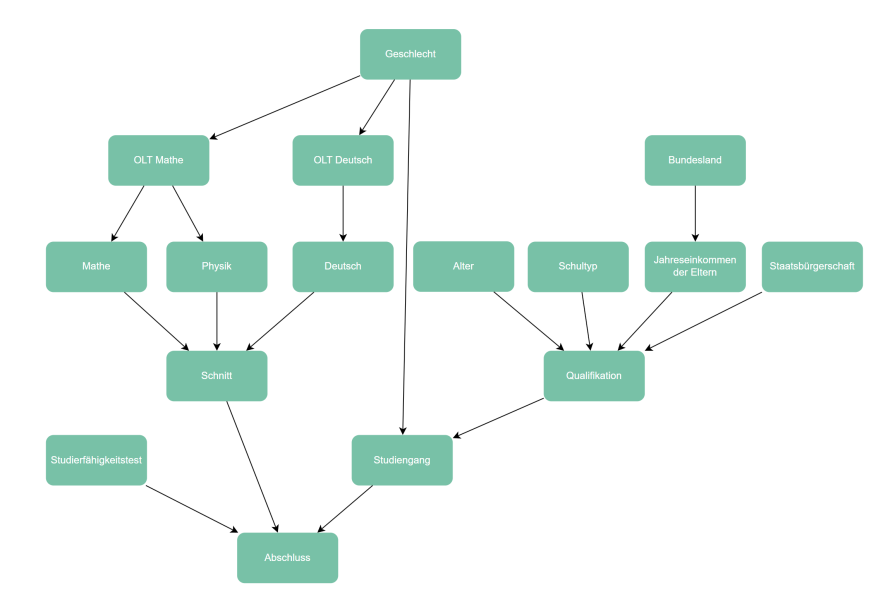

In [152]:
# Create Bayesian Network
G = BayesianNetwork()
G.add_nodes_from(init_data.columns)
display(init_data)

# Add edges to the network
G.add_edges_from([
    (Geschl, OLTM),
    (Geschl, OLTD),
    (OLTM, M),
    (OLTM, P),
    (OLTD, D),
    (M, S),
    (P, S),
    (D, S),
    (SFT, Absch),
    (S, Absch),
    (Geschl, SG),
    (SG, Absch),
    (A, Quali),
    (ST, Quali),
    (BL, JEDE),
    (JEDE, Quali),
    (SB, Quali)
])

# Use BayesianEstimator to learn the CPDs
G.fit(data=init_data, estimator=BayesianEstimator)

,Qualifikation,Schnitt,Bundesland,Mathe,Physik,Deutsch,Schultyp,OLT-Mathe,OLT-Deutsch,Studierfähigkeitstest,Alter,Geschlecht,Jahreseinkommen der Eltern,Staatsbürgerschaft,Studiengang,Abschluss
0,Abitur,Gut,Baden-Württemberg,Gut,Gut,Gut,Allgemeinbildendes Gymnasium,Gut,Gut,Gut,Teen,m,Gering,deutsch,Maschinenbau,bestehen
1,Meister,Sehr Gut,Nordrhein-Westfalen,<NA>,<NA>,<NA>,n.a.,Schlecht,Gut,<NA>,Adult,m,Mittel,deutsch,Maschinenbau,abgebrochen
2,Abitur,Sehr Gut,Baden-Württemberg,Sehr Gut,Sehr Gut,Sehr Gut,Wirtschaftsgymnasium,Sehr Gut,Sehr Gut,<NA>,Teen,w,Hoch,deutsch,Soziale Arbeit,gut
3,Abitur,Sehr Gut,Baden-Württemberg,Gut,Gut,Sehr Gut,Technisches Gymnasium,Gut,Sehr Gut,<NA>,Teen,m,Hoch,deutsch,Elektrotechnik,bestehen
4,Abitur,Sehr Gut,Bayern,Gut,Gut,Sehr Gut,Wirtschaftsgymnasium,Gut,Sehr Gut,<NA>,Teen,m,Mittel,deutsch,Elektrotechnik,gut
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,Abitur,Sehr Gut,Baden-Württemberg,Gut,Gut,Gut,Allgemeinbildendes Gymnasium,Gut,Gut,NaN,Teen,w,Hoch,deutsch,Elektrotechnik,bestehen
96,Abitur,Gut,Baden-Württemberg,Sehr Gut,Sehr Gut,Sehr Gut,Technisches Gymnasium,Sehr Gut,Sehr Gut,NaN,YoungAdult,m,Mittel,deutsch,Wirtschaftswissenschaften,gut
97,Abitur,Sehr Gut,Baden-Württemberg,Gut,Gut,Sehr Gut,Technisches Gymnasium,Sehr Gut,Sehr Gut,NaN,Teen,m,Hoch,deutsch,Maschinenbau,gut
98,Abitur,Gut,Bayern,Sehr Gut,Sehr Gut,Sehr Gut,Allgemeinbildendes Gymnasium,Sehr Gut,Sehr Gut,NaN,Teen,m,Hoch,deutsch,Maschinenbau,gut


# Test prediction

Makes a test prediction to verify the Bayesian Network

In [141]:
# Perform inference with incomplete input
# Example: Predict Abschluss for a student with Qualifikation = "Abitur",
# Schultyp = "Allgemeinbildendes Gymnasium", BL = "Baden-Württemberg",
# and A = 22
evidence = {
    Quali: "Abitur",
    ST: "Allgemeinbildendes Gymnasium",
    BL: "Baden-Württemberg",
    A: "Adult"
}

# Use Variable Elimination to make predictions
infer = VariableElimination(G)
print(evidence)
q = infer.query(variables=[Absch], evidence=evidence)
print(q)

{'Qualifikation': 'Abitur', 'Schultyp': 'Allgemeinbildendes Gymnasium', 'Bundesland': 'Baden-Württemberg', 'Alter': 'Adult'}
+------------------------+------------------+
| Abschluss              |   phi(Abschluss) |
+========================+==================+
| Abschluss(abgebrochen) |           0.2914 |
+------------------------+------------------+
| Abschluss(bestehen)    |           0.3701 |
+------------------------+------------------+
| Abschluss(gut)         |           0.3385 |
+------------------------+------------------+


# Test

Loads "new_data.csv" and runs a prediction using the created model

In [155]:
#Load data from "new_data.csv" 
test_data = pd.read_csv('new_data.csv', sep=';',dtype=str)

#Set empty Colums to NA
for column in test_data.columns:
    if test_data[column][0] == "":
        test_data[column][0] = pd.NA

#Parse and transform raw data
test_data = parse_df(test_data)
test_data = transform_data(test_data)

#Remove NA Columns
for column in test_data.columns:
    if pd.isna(test_data[column][0]):
        test_data = test_data.drop(columns=column)

# Use Variable Elimination to make prediction
infer = VariableElimination(G)
q = infer.query(variables=[Absch], evidence=test_data.to_dict(orient='records')[0])
print(q)

+------------------------+------------------+
| Abschluss              |   phi(Abschluss) |
+========================+==================+
| Abschluss(abgebrochen) |           0.3333 |
+------------------------+------------------+
| Abschluss(bestehen)    |           0.3333 |
+------------------------+------------------+
| Abschluss(gut)         |           0.3333 |
+------------------------+------------------+
